Prediction Target: When will the case reach "Send For Credit Collection"?
 - Target Feature: time until completion ("Send For Credit Collection" is reached)

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import pm4py
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

## Data Exploration and Preparation

Goals: 
- Learn about the event log in terms of features that we can use for the prediction task
- prepare the data in a way that it does not bias the prediction

In [2]:
data = pm4py.read_xes("data/Road_Traffic_Fine_Management_Process.xes")
display(data)

case_id_col = "case:concept:name"
activity_col = "concept:name"
timestamp_col = "time:timestamp"

data[timestamp_col] = pd.to_datetime(data[timestamp_col])


# Get unique cases
case_ids = data[case_id_col].unique()

# Split 80/20 by case
train_cases, test_cases = train_test_split(
    case_ids, 
    test_size=0.2, 
    random_state=42
)

# Create train and test logs
train_log = data[data[case_id_col].isin(train_cases)]
test_log = data[data[case_id_col].isin(test_cases)]

print(f"Train cases: {len(train_cases)}")
print(f"Test cases: {len(test_cases)}")

/Users/samuelwidmer/Desktop/Bachelors-Thesis/.venv/lib/python3.14/site-packages/pm4py/utils.py:992: UserWarning: Install the optional requirement `rustxes` to import/export files faster.
  warnings.warn("Install the optional requirement `rustxes` to import/export files faster.")


parsing log, completed traces ::   0%|          | 0/150370 [00:00<?, ?it/s]

,amount,org:resource,dismissal,concept:name,vehicleClass,totalPaymentAmount,lifecycle:transition,time:timestamp,article,points,case:concept:name,expense,notificationType,lastSent,paymentAmount,matricola
0,35.0,561,NIL,Create Fine,A,0.0,complete,2006-07-24 00:00:00+00:00,157.0,0.0,A1,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,Send Fine,NaN,NaN,complete,2006-12-05 00:00:00+00:00,NaN,NaN,A1,11.00,NaN,NaN,NaN,NaN
2,35.0,561,NIL,Create Fine,A,0.0,complete,2006-08-02 00:00:00+00:00,157.0,0.0,A100,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,Send Fine,NaN,NaN,complete,2006-12-12 00:00:00+00:00,NaN,NaN,A100,11.00,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,Insert Fine Notification,NaN,NaN,complete,2007-01-15 00:00:00+00:00,NaN,NaN,A100,NaN,P,P,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
561465,131.0,25,NIL,Create Fine,A,0.0,complete,2002-09-07 00:00:00+00:00,142.0,0.0,V9999,NaN,NaN,NaN,NaN,NaN
561466,NaN,NaN,NaN,Send Fine,NaN,NaN,complete,2002-10-25 00:00:00+00:00,NaN,NaN,V9999,15.16,NaN,NaN,NaN,NaN
561467,NaN,NaN,NaN,Insert Fine Notification,NaN,NaN,complete,2002-11-04 00:00:00+00:00,NaN,NaN,V9999,NaN,P,N,NaN,NaN
561468,262.0,NaN,NaN,Add penalty,NaN,NaN,complete,2003-01-03 00:00:00+00:00,NaN,NaN,V9999,NaN,NaN,NaN,NaN,NaN


Train cases: 120296
Test cases: 30074


## Prefix Extraction
Goal:
- Derive labeled prefixes for each trace in the log.
We want to make predictions on incomplete cases. Therefore, we need to learn from correlations between incomplete traces and our prediction target. 


### Extraction using Fixed Max Prefix Length

In [ ]:
def extract_prefixes_for_regression(log, prefix_length):
    """
    Extract prefixes and calculate time until 'Send for Credit Collection'
    """
    log = log.sort_values([case_id_col, timestamp_col])
    
    all_prefixes = []
    
    for case_id, group in log.groupby(case_id_col):
        for i in range(1, prefix_length + 1):
            # Skip if case is too short
            if len(group) < i:
                continue
        
            # Check if "Send for Credit Collection" exists in this case
            credit_collection_events = group[group[activity_col] == 'Send for Credit Collection']
        
            if len(credit_collection_events) == 0:
                continue
        
            # Get the timestamp when credit collection occurs
            credit_collection_time = credit_collection_events.iloc[0][timestamp_col]
        
            # Get prefix (first N events)
            prefix = group.iloc[:i].copy()
        
            # Time of last event in prefix
            prefix_end_time = prefix.iloc[-1][timestamp_col]
        
            # Check if credit collection happens after the prefix
            if credit_collection_time <= prefix_end_time:
                continue
        
            # Calculate target: time from end of prefix to credit collection (in days)
            time_to_credit_collection = (credit_collection_time - prefix_end_time).total_seconds() / (24 * 3600)
        
            # Create feature row for this prefix
            features = {}
            features['case_id'] = case_id
            features['prefix_length'] = i
        
            # Last state features
            last_event = prefix.iloc[-1]
            features['last_activity'] = last_event[activity_col]
            features['last_resource'] = last_event['org:resource']
    
            # Static case attributes
            features['amount'] = prefix['amount'].iloc[0]
            features['points'] = prefix['points'].iloc[0]
            features['article'] = prefix['article'].iloc[0]
            features['vehicleClass'] = prefix['vehicleClass'].iloc[0]
        
            # Aggregated features
            features['num_events'] = len(prefix)
            features['total_expense'] = prefix['expense'].sum()
        
            # Count specific activities
            features['num_send_fine'] = (prefix[activity_col] == 'Send Fine').sum()
            features['num_insert_fine_notification'] = (prefix[activity_col] == 'Insert Fine Notification').sum()
            features['num_add_penalty'] = (prefix[activity_col] == 'Add penalty').sum()
            features['has_payment'] = int('Payment' in prefix[activity_col].values)
            features['has_appeal'] = int('Appeal to Judge' in prefix[activity_col].values)
        
            # Resource diversity
            features['num_unique_resources'] = prefix['org:resource'].nunique()

            # Time-based features
            
            # Fine to penalty delay
            if 'Send Fine' in prefix[activity_col].values and 'Add penalty' in prefix[activity_col].values:
                fine_time = prefix[prefix[activity_col] == 'Send Fine'].iloc[0][timestamp_col]
                penalty_time = prefix[prefix[activity_col] == 'Add penalty'].iloc[0][timestamp_col]
                features['fine_to_penalty_delay'] = (penalty_time - fine_time).total_seconds() / (24 * 3600)
            else:
                features['fine_to_penalty_delay'] = -1

            # Prefix duration
            features['prefix_duration_days'] = (prefix_end_time - prefix.iloc[0][timestamp_col]).total_seconds() / (24 * 3600)
            
            # Process velocity
            if len(prefix) > 1:
                time_diffs = prefix[timestamp_col].diff().dropna().dt.total_seconds() / (24 * 3600)
                features['avg_time_between_events'] = time_diffs.mean()
                features['max_time_between_events'] = time_diffs.max()
            else:
                features['avg_time_between_events'] = 0
                features['max_time_between_events'] = 0
            
            # Days since key events
            if 'Send Fine' in prefix[activity_col].values:
                fine_time = prefix[prefix[activity_col] == 'Send Fine'].iloc[0][timestamp_col]
                features['days_since_fine'] = (prefix_end_time - fine_time).total_seconds() / (24 * 3600)
            else:
                features['days_since_fine'] = -1

            if 'Add penalty' in prefix[activity_col].values:
                penalty_time = prefix[prefix[activity_col] == 'Add penalty'].iloc[0][timestamp_col]
                features['days_since_penalty'] = (prefix_end_time - penalty_time).total_seconds() / (24 * 3600)
            else:
                features['days_since_penalty'] = -1
            
            # Seasonal features
            features['start_day_of_week'] = prefix.iloc[0][timestamp_col].dayofweek
            features['start_month'] = prefix.iloc[0][timestamp_col].month
        
            # Regression target
            features['time_to_credit_collection_days'] = time_to_credit_collection
        
            all_prefixes.append(features)
    
    return pd.DataFrame(all_prefixes)

In [ ]:
# Choose prefix length
# Try prefixes up to a certain time threshold
PREFIX_LENGTH = 5

# Extract prefixes from train and test
train_data = extract_prefixes_for_regression(train_log, PREFIX_LENGTH)
test_data = extract_prefixes_for_regression(test_log, PREFIX_LENGTH)

print(f"\nTraining samples: {len(train_data)}")
print(f"Test samples: {len(test_data)}")

# Check target distribution
print(f"\nTarget statistics (days until credit collection):")
print(train_data['time_to_credit_collection_days'].describe())

# Display first few rows
display(train_data.head())


Training samples: 190736
Test samples: 47847

Target statistics (days until credit collection):
count    190736.000000
mean        602.587687
std         201.731867
min          34.000000
25%         457.000000
50%         564.000000
75%         696.000000
max        3437.000000
Name: time_to_credit_collection_days, dtype: float64


,case_id,prefix_length,last_activity,last_resource,amount,points,article,vehicleClass,num_events,total_expense,...,num_unique_resources,fine_to_penalty_delay,prefix_duration_days,avg_time_between_events,max_time_between_events,days_since_fine,days_since_penalty,start_day_of_week,start_month,time_to_credit_collection_days
0,A100,1,Create Fine,561,35.0,0.0,157.0,A,1,0.0,...,1,-1.0,0.0,0.000000,0.0,-1.0,-1.0,2,8,971.0
1,A100,2,Send Fine,NaN,35.0,0.0,157.0,A,2,11.0,...,1,-1.0,132.0,132.000000,132.0,0.0,-1.0,2,8,839.0
2,A100,3,Insert Fine Notification,NaN,35.0,0.0,157.0,A,3,11.0,...,1,-1.0,166.0,83.000000,132.0,34.0,-1.0,2,8,805.0
3,A100,4,Add penalty,NaN,35.0,0.0,157.0,A,4,11.0,...,1,94.0,226.0,75.333333,132.0,94.0,0.0,2,8,745.0
4,A10008,1,Create Fine,537,36.0,0.0,157.0,A,1,0.0,...,1,-1.0,0.0,0.000000,0.0,-1.0,-1.0,1,3,741.0


### Prefix Extraction using Fixed Day Length

In [ ]:
def extract_prefixes_by_multiple_thresholds(log, thresholds_days=[30, 60, 90, 120, 150, 180]):
    """
    Extract prefixes based on multiple time thresholds and calculate time until 'Send for Credit Collection'
    Creates one sample per case per threshold (similar to prefix length approach)
    """
    log = log.sort_values([case_id_col, timestamp_col])
    
    all_prefixes = []
    
    for case_id, group in log.groupby(case_id_col):
        # Check if "Send for Credit Collection" exists in this case
        credit_collection_events = group[group[activity_col] == 'Send for Credit Collection']
        
        if len(credit_collection_events) == 0:
            continue
        
        # Get the timestamp when credit collection occurs
        credit_collection_time = credit_collection_events.iloc[0][timestamp_col]
        
        # Get case start time
        case_start = group[timestamp_col].min()
        
        for threshold in thresholds_days:
            # Calculate threshold cutoff
            threshold_cutoff = case_start + pd.Timedelta(days=threshold)
            
            # Get events within the time window
            prefix = group[group[timestamp_col] <= threshold_cutoff].copy()
            
            # Skip if no events in window or credit collection already happened
            if len(prefix) == 0:
                continue
            if credit_collection_time <= threshold_cutoff:
                continue
            
            # Calculate target: time from threshold cutoff to credit collection (in days)
            time_to_credit_collection = (credit_collection_time - threshold_cutoff).total_seconds() / (24 * 3600)
            
            # Create feature row
            features = {}
            features['case_id'] = case_id
            features['time_threshold_days'] = threshold
            features['prefix_length'] = len(prefix)
            
            # Last state features
            last_event = prefix.iloc[-1]
            features['last_activity'] = last_event[activity_col]
            features['last_resource'] = last_event['org:resource']
            
            # Static case attributes
            features['amount'] = prefix['amount'].iloc[0]
            features['points'] = prefix['points'].iloc[0]
            features['article'] = prefix['article'].iloc[0]
            features['vehicleClass'] = prefix['vehicleClass'].iloc[0]
            
            # Aggregated features
            features['num_events'] = len(prefix)
            features['total_expense'] = prefix['expense'].sum()
            
            # Count specific activities
            features['num_send_fine'] = (prefix[activity_col] == 'Send Fine').sum()
            features['num_insert_fine_notification'] = (prefix[activity_col] == 'Insert Fine Notification').sum()
            features['num_add_penalty'] = (prefix[activity_col] == 'Add penalty').sum()
            features['has_payment'] = int('Payment' in prefix[activity_col].values)
            features['has_appeal'] = int('Appeal to Judge' in prefix[activity_col].values)
            
            # Resource diversity
            features['num_unique_resources'] = prefix['org:resource'].nunique()
            
            # Time-based features
            if 'Send Fine' in prefix[activity_col].values and 'Add penalty' in prefix[activity_col].values:
                fine_time = prefix[prefix[activity_col] == 'Send Fine'].iloc[0][timestamp_col]
                penalty_time = prefix[prefix[activity_col] == 'Add penalty'].iloc[0][timestamp_col]
                features['fine_to_penalty_delay'] = (penalty_time - fine_time).total_seconds() / (24 * 3600)
            
            # Regression target
            features['time_to_credit_collection_days'] = time_to_credit_collection
            
            all_prefixes.append(features)
    
    return pd.DataFrame(all_prefixes)


# Usage
THRESHOLDS = [30, 60, 90, 120, 150, 180]

train_data = extract_prefixes_by_multiple_thresholds(train_log, THRESHOLDS)
test_data = extract_prefixes_by_multiple_thresholds(test_log, THRESHOLDS)

print(f"Training samples: {len(train_data)}")
print(f"Test samples: {len(test_data)}")
print(f"\nSamples per threshold:")
print(train_data['time_threshold_days'].value_counts().sort_index())
print(f"\nEvents captured per threshold:")
print(train_data.groupby('time_threshold_days')['num_events'].mean())
print(f"\nTarget statistics:")
print(train_data['time_to_credit_collection_days'].describe())

Training samples: 283062
Test samples: 71016

Samples per threshold:
time_threshold_days
30     47177
60     47177
90     47177
120    47177
150    47177
180    47177
Name: count, dtype: int64

Events captured per threshold:
time_threshold_days
30     1.104119
60     1.524917
90     2.019522
120    2.570744
150    3.301439
180    3.637874
Name: num_events, dtype: float64

Target statistics:
count    283062.000000
mean        585.579562
std         203.633243
min          93.000000
25%         447.000000
50%         538.000000
75%         673.000000
max        3407.000000
Name: time_to_credit_collection_days, dtype: float64


In [ ]:
# Check if the threshold is actually filtering anything
for threshold in [7, 30, 60, 90, 180]:
    train_t = extract_prefixes_by_multiple_thresholds(train_log, threshold)
    
    print(f"\nThreshold: {threshold} days")
    print(f"  Samples: {len(train_t)}")
    print(f"  Avg events captured: {train_t['num_events'].mean():.2f}")
    print(f"  Avg target (remaining days): {train_t['time_to_credit_collection_days'].mean():.1f}")


Threshold: 7 days
  Samples: 47177
  Avg events captured: 1.07
  Avg target (remaining days): 683.6

Threshold: 30 days
  Samples: 47177
  Avg events captured: 1.10
  Avg target (remaining days): 660.6

Threshold: 60 days
  Samples: 47177
  Avg events captured: 1.52
  Avg target (remaining days): 630.6

Threshold: 90 days
  Samples: 47177
  Avg events captured: 2.02
  Avg target (remaining days): 600.6

Threshold: 180 days
  Samples: 47177
  Avg events captured: 3.64
  Avg target (remaining days): 510.6


In [ ]:
# Check relationship between time elapsed and events completed
case_stats = train_log.groupby('case:concept:name').agg({
    'time:timestamp': ['min', 'max', 'count']
}).reset_index()

case_stats.columns = ['case_id', 'start', 'end', 'num_events']
case_stats['duration_days'] = (case_stats['end'] - case_stats['start']).dt.days

# Is there a consistent relationship?
print(case_stats[['num_events', 'duration_days']].corr())
print(case_stats[['num_events', 'duration_days']].describe())

               num_events  duration_days
num_events        1.00000        0.75274
duration_days     0.75274        1.00000
          num_events  duration_days
count  120296.000000  120296.000000
mean        3.733092     341.582122
std         1.641582     346.872396
min         2.000000       0.000000
25%         2.000000      12.000000
50%         5.000000     198.000000
75%         5.000000     605.000000
max        20.000000    4352.000000


## Bucketing

## Feature Engineering & Encoding

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Separate features and target
feature_cols = [col for col in train_data.columns 
                if col not in ['case_id', 'time_to_credit_collection_days']]
categorical_cols = ['last_activity', 'last_resource', 'article', 'vehicleClass']

X_train = train_data[feature_cols].copy()
y_train = train_data['time_to_credit_collection_days']

X_test = test_data[feature_cols].copy()
y_test = test_data['time_to_credit_collection_days']

# Label encode categorical variables (convert to integers)
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    # Fit on combined data to handle unseen categories
    le.fit(pd.concat([X_train[col], X_test[col]]).astype(str))
    X_train[col] = le.transform(X_train[col].astype(str))
    X_test[col] = le.transform(X_test[col].astype(str))
    label_encoders[col] = le

print(f"\nFeature matrix shape:")
print(f"Train: {X_train.shape}")
print(f"Test: {X_test.shape}")
display(X_train.head())


Feature matrix shape:
Train: (190736, 23)
Test: (47847, 23)


,prefix_length,last_activity,last_resource,amount,points,article,vehicleClass,num_events,total_expense,num_send_fine,...,has_appeal,num_unique_resources,fine_to_penalty_delay,prefix_duration_days,avg_time_between_events,max_time_between_events,days_since_fine,days_since_penalty,start_day_of_week,start_month
0,1,2,67,35.0,0.0,20,0,1,0.0,0,...,0,1,-1.0,0.0,0.000000,0.0,-1.0,-1.0,2,8
1,2,9,139,35.0,0.0,20,0,2,11.0,1,...,0,1,-1.0,132.0,132.000000,132.0,0.0,-1.0,2,8
2,3,4,139,35.0,0.0,20,0,3,11.0,1,...,0,1,-1.0,166.0,83.000000,132.0,34.0,-1.0,2,8
3,4,0,139,35.0,0.0,20,0,4,11.0,1,...,0,1,94.0,226.0,75.333333,132.0,94.0,0.0,2,8
4,1,2,47,36.0,0.0,20,0,1,0.0,0,...,0,1,-1.0,0.0,0.000000,0.0,-1.0,-1.0,1,3


## Model Building and Training



In [ ]:
# Train regression model
reg = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10)
reg.fit(X_train, y_train)

# Predict
y_pred = reg.predict(X_test)

# Evaluate
print("\nRegression Model Performance:")
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.2f} days")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f} days")
print(f"R^2 Score: {r2:.3f}")

# Show some predictions vs actual
comparison = pd.DataFrame({
    'Actual_Days': y_test.values[:10],
    'Predicted_Days': y_pred[:10],
    'Error_Days': np.abs(y_test.values[:10] - y_pred[:10])
})
print("\nSample Predictions:")
print(comparison)

# Feature importance
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': reg.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))


Regression Model Performance:
Mean Absolute Error (MAE): 85.14 days
Root Mean Squared Error (RMSE): 140.35 days
R^2 Score: 0.505

Sample Predictions:
   Actual_Days  Predicted_Days  Error_Days
0        741.0      765.812369   24.812369
1        622.0      655.767803   33.767803
2        615.0      655.767803   40.767803
3        555.0      572.003253   17.003253
4        733.0      731.983123    1.016877
5        606.0      665.153804   59.153804
6        580.0      646.244708   66.244708
7        520.0      602.621131   82.621131
8        753.0      774.656697   21.656697
9        622.0      655.398282   33.398282

Top 10 Most Important Features:
                    feature  importance
3                    amount    0.345496
22              start_month    0.218936
2             last_resource    0.127072
8             total_expense    0.081094
19          days_since_fine    0.073687
18  max_time_between_events    0.063417
5                   article    0.017103
16     prefix_duration_

## Evaluation

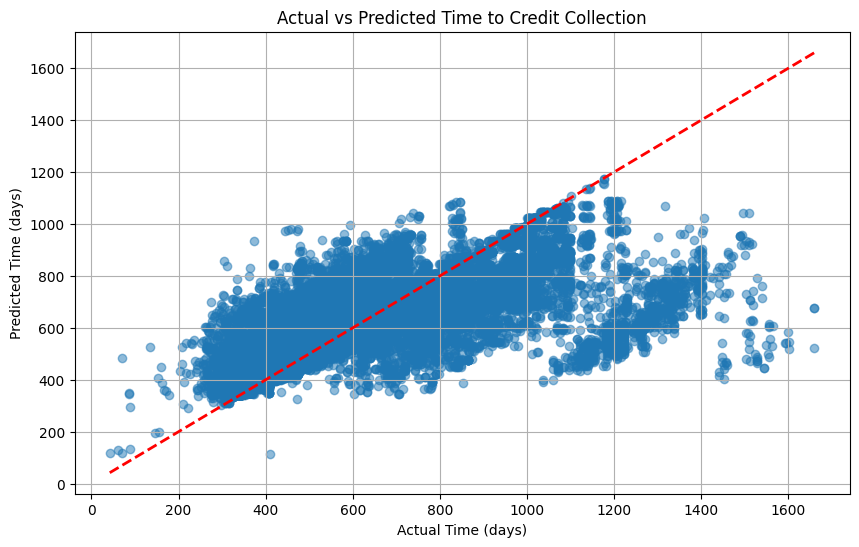

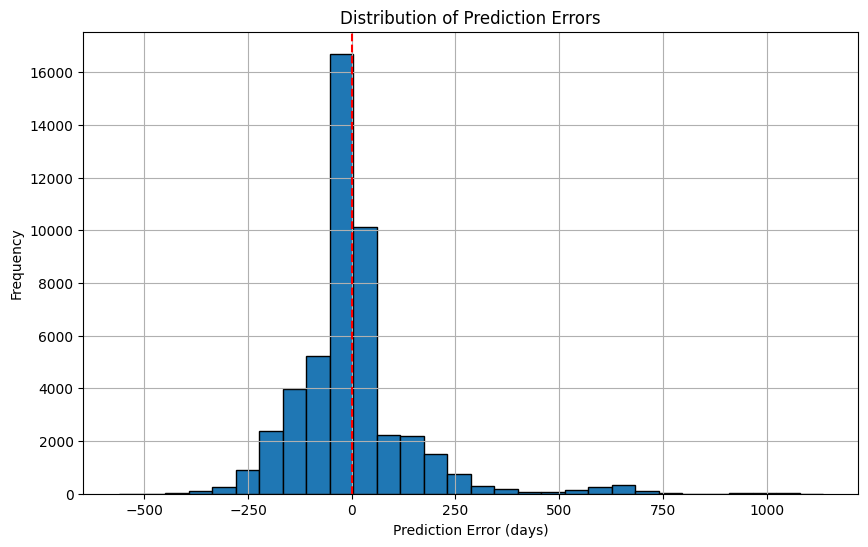

In [ ]:
# Add Marginal Scatter Plots with Visualizations for each axis (see medium article) --> See where predictions land
# Check out how to render images on GitHub/Marimo (Screenshots)
# Complement Chart with Absolute Time


# Scatter plot: Actual vs Predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Time (days)')
plt.ylabel('Predicted Time (days)')
plt.title('Actual vs Predicted Time to Credit Collection')
plt.grid(True)
plt.show()

# Distribution of errors
errors = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.hist(errors, bins=30, edgecolor='black')
plt.xlabel('Prediction Error (days)')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Errors')
plt.axvline(x=0, color='r', linestyle='--')
plt.grid(True)
plt.show()

In [ ]:


# Create dataframe for plotting
plot_df = pd.DataFrame({
    'Actual Time (days)': y_test.values,
    'Predicted Time (days)': y_pred
})

# Scatter plot with marginal histograms
fig = px.scatter(
    plot_df, 
    x='Actual Time (days)', 
    y='Predicted Time (days)',
    marginal_x='histogram',  # Distribution of actual values
    marginal_y='histogram',  # Distribution of predicted values
    title='Actual vs Predicted Time to Credit Collection',
    opacity=0.5
)

# Add perfect prediction line (y = x)
fig.add_shape(
    type='line',
    x0=plot_df['Actual Time (days)'].min(),
    y0=plot_df['Actual Time (days)'].min(),
    x1=plot_df['Actual Time (days)'].max(),
    y1=plot_df['Actual Time (days)'].max(),
    line=dict(color='red', dash='dash', width=2)
)

fig.update_layout(width=800, height=700)
fig.show()

NameError: name 'y_test' is not defined

## Interpretation